### Final model for BTC Trend Prediction

This code is a pipeline for building a Recurrent Neural Network (RNN) model to predict the future trend of BTC prices. 

The code can be broken down and understood in the following way:

1. **Data Preprocessing**:
   - `remove_outlier`: Removes outliers based on the interquartile range (IQR) of the 'volume' column.
   - `read_hist_data`: Reads historical data for a given cryptocurrency (default is BTC) and timeframe (default is 1h). It cleans the data by setting the datetime as the index and removing outliers.
   - `get_target_next_ema_diff_v2`: This function calculates the Exponential Moving Averages (EMAs) of the price and computes their difference to set a target label for the trend.
   - `get_features_v2`: This function creates a set of lagged features for the model. For a given number of periods `T`, it generates the percentage change and lagged values for the open, high, low, close, and volume columns.

2. **Deep Learning Model**:
   - The deep learning model uses LSTM layers, which are a type of RNN. As time series data and LSTMs are designed to remember patterns over long sequences.
   - Regularization: To prevent overfitting, L2 regularization is added to the LSTM layers.
   - Dropout: Each LSTM layer is followed by a Dropout layer to further mitigate overfitting.
   - BatchNormalization: This is used to normalize the activations of the neurons in the LSTM layers.
   - The final layer is a Dense layer with a softmax activation, which outputs the probability distribution over the six trend classes.

3. **Training the Model**:
   - `train_dl_trend_prediction_model`: This is the main function to train the deep learning model.
     - The target labels are one-hot encoded using `OneHotEncoder`.
     - Data is split into training and test sets.
     - Features are standardized using `StandardScaler`.
     - The LSTM model is constructed and compiled.
     - Early stopping is implemented to halt training if the validation loss doesn't improve for a set number of epochs.
     - The model is trained using the Adam optimizer with a specified learning rate.

4. **Evaluating the Model**:
   - After training, the model's performance is evaluated using `eval_classification_model`.
   - Additionally, a training evaluation plot is generated using `plot_rnn_training_eval`.

5. **Miscellaneous**:
   - Model, scaler, and encoder are saved for later use, allowing us to preprocess new data and make predictions with the trained model without retraining.


Predict target labels:
- -3 = strong down trend
- -2 = weak down trend
- -1 = slightly down trend
- +1 = slightly up trend
- +2 = weak up trend
- +3 = strong up trend

In [10]:
import numpy as np
import pandas as pd
import talib

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

In [11]:
def get_target_next_ema_diff_v2(df, target_shift = 3):
    
    target_threshold = 0.2
    # oclh
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # diff between ema 10 and 20
    df['ema_10'] = talib.EMA(df['ohlc'], timeperiod=10)
    df['ema_20'] = talib.EMA(df['ohlc'], timeperiod=20)
    df['ema_diff'] = (df['ema_10'] - df['ema_20']) / df['ohlc'] * 100

    conditions = [
        (df['ema_diff'].isnull()),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] > df['ema_diff'].shift(1)),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] <= df['ema_diff'].shift(1)),
        (df['ema_diff'] > 0) & (df['ema_diff'] <= target_threshold),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] < df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] >= df['ema_diff'].shift(1)),
        (df['ema_diff'] <= 0) & (df['ema_diff'] >= target_threshold * -1)
    ]
    values = [np.nan, 3, 2, 1, -3, -2, -1]
    df['target'] = np.select(conditions, values, default=1,)

    # shift target
    df['target'] = df['target'].shift(target_shift * -1)

    # drop columns
    df.drop(columns=['ohlc', 'ema_10', 'ema_20', 'ema_diff'], inplace=True)

    return df


In [12]:
import numpy as np
import pandas as pd

def get_features_v2(df, T=3):

    df = df.copy()

    # ++ Features ++
    inputs = ['open', 'high', 'low', 'close', 'volume'] 

    # log volume
    df.loc[:, 'volume'] = np.log(df['volume'])

    # range from 1 to T
    lags = [x for x in range(0, T)]

    # loop lags
    for lag in lags:
        # loop periods and inputs
        for input in inputs:
            if lag == 0:
                # % of change
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[input].pct_change(periods=1))

            else:
                # use lagged price, sort from oldest to newest
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[f'{input}_lag0'].shift(lag))

        df = df.copy()

    # drop unused columns
    drop_columns = ['open', 'high', 'low', 'close','volume']
    df.drop(columns=drop_columns, inplace=True)

    return df

In [13]:
T = 72 # number of periods to use as input features (time steps)
predict_period = 1 # number of periods to predict (time steps)

df = read_hist_data()
df = get_target_next_ema_diff_v2(df, target_shift=predict_period)
df = get_features_v2(df, T=T)
df = df.dropna()

F = int((df.shape[1] -1) / T) # number of input features 
C = 6 # number of classes

# print(df.head(10))
# print(df.tail(10))

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()

Count target
-1.0    4970
 1.0    4765
 2.0    3913
-2.0    3820
 3.0    3394
-3.0    3353
Name: count, dtype: int64
Data shape:  (24215, 361)
Input shape: (72, 5)


,volume_lag71,close_lag71,low_lag71,high_lag71,open_lag71,volume_lag70,close_lag70,low_lag70,high_lag70,open_lag70,...,close_lag1,low_lag1,high_lag1,open_lag1,volume_lag0,close_lag0,low_lag0,high_lag0,open_lag0,target
count,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,...,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000,24215.000000
mean,0.001904,0.000026,0.000028,0.000021,0.000026,0.001902,0.000025,0.000028,0.000021,0.000026,...,0.000022,0.000024,0.000017,0.000022,0.001903,0.000022,0.000024,0.000017,0.000022,0.004295
std,0.064118,0.007282,0.007539,0.006676,0.007358,0.064115,0.007281,0.007538,0.006675,0.007358,...,0.007247,0.007510,0.006656,0.007324,0.064142,0.007247,0.007509,0.006656,0.007324,2.046272
min,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,...,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-3.000000
25%,-0.036137,-0.002574,-0.002236,-0.002402,-0.002568,-0.036137,-0.002574,-0.002236,-0.002402,-0.002568,...,-0.002565,-0.002231,-0.002397,-0.002562,-0.036151,-0.002565,-0.002231,-0.002397,-0.002562,-2.000000
50%,-0.004067,0.000028,0.000265,-0.000235,0.000026,-0.004067,0.000028,0.000265,-0.000235,0.000025,...,0.000028,0.000264,-0.000235,0.000025,-0.004057,0.000028,0.000264,-0.000235,0.000025,-1.000000
75%,0.032850,0.002650,0.002659,0.002142,0.002649,0.032850,0.002650,0.002658,0.002142,0.002649,...,0.002644,0.002643,0.002140,0.002642,0.032870,0.002644,0.002643,0.002140,0.002642,2.000000
max,2.849711,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,...,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,3.000000


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

def plot_rnn_training_eval(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

    return None

def eval_classification_model(model, X_test, y_test, one_hot_encoder):
    y_pred = model.predict(X_test, verbose=0)

    # reverse one-hot encoding
    y_test = one_hot_encoder.inverse_transform(y_test)
    y_pred = one_hot_encoder.inverse_transform(y_pred)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    classes = ['-3.0', '-2.0', '-1.0', '1.0', '2.0', '3.0']

    # Confusion Matrix
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', ax=ax[0])
    ax[0].set_xticklabels(classes, rotation=45)
    ax[0].set_yticklabels(classes, rotation=0)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')
    ax[0].set_title("Confusion Matrix")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, target_names=classes)
    row_data = [["", "precision", "recall", "f1-score", "support"]]
    for k, v in report.items():
        if k not in ["accuracy"]:
            row_data.append([f"{k}"] + [f'{v[i]:.2f}' for i in ["precision", "recall", "f1-score", "support"]])
    row_data.append(["accuracy", "", "", f"{report['accuracy']:.2f}", ""])

    ax[1].axis('off')
    table = ax[1].table(cellText=row_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
    table.scale(1, 2)

    # Style the table with similar colors of the heatmap
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor('#2c7bb6')  # Header cells color
        else:
            cell.set_facecolor('#f5f5f5')  # Rest of the table color
        cell.set_edgecolor('w')  # Border color

    table.auto_set_column_width(col=list(range(5)))
    ax[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    return None

def train_dl_trend_prediction_model(df, T, model_name = 'tmp_model', model_path = './models/', test_size=0.1, random_state = 55, epochs=50, show_eval=True):
    time_start = time.time()

    # Pre-processing 
    drop_columns = ['target']
    X = df.drop(columns=drop_columns)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

    # save encoder
    encoder_filepath = model_path + model_name + '_encoder.joblib'
    joblib.dump(encoder, encoder_filepath)

    # Dimension parameters
    F = int((df.shape[1] -1) / T) # number of input features 
    C = y.shape[1] # number of classes
    # print(f"Input shape: ({T}, {F})")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    # Fit the scaler using the training data
    scaler = StandardScaler()
    
    X_train_pre = scaler.fit_transform(X_train)
    X_test_pre = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)

    X_train_pre = X_train_pre.reshape(-1, T, F)
    X_test_pre = X_test_pre.reshape(-1, T, F)

    # data set = (X_train_pre, y_train), (X_test_pre, y_test)

    # Deep learning model
    input_shape = (T, F) # (time_steps, features)

    # Create the LSTM model
    model = Sequential()

    model.add(LSTM(units=60, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(BatchNormalization()) 

    model.add(LSTM(units=30, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization()) 

    # Output layer
    model.add(Dense(units=C, activation='softmax'))

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)     # set learning rate
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train_pre, y_train, epochs=epochs, batch_size=128, validation_data=(X_test_pre, y_test), callbacks=[early_stop], verbose=0)

    # save deep learning model
    model_filepath = model_path + model_name + '_model.keras'
    model.save(model_filepath)

    # return model, X_test_pre, y_test, encoder, scaler, history

    if show_eval:
        plot_rnn_training_eval(history)
        eval_classification_model(model, X_test_pre, y_test, one_hot_encoder=encoder)

    return model



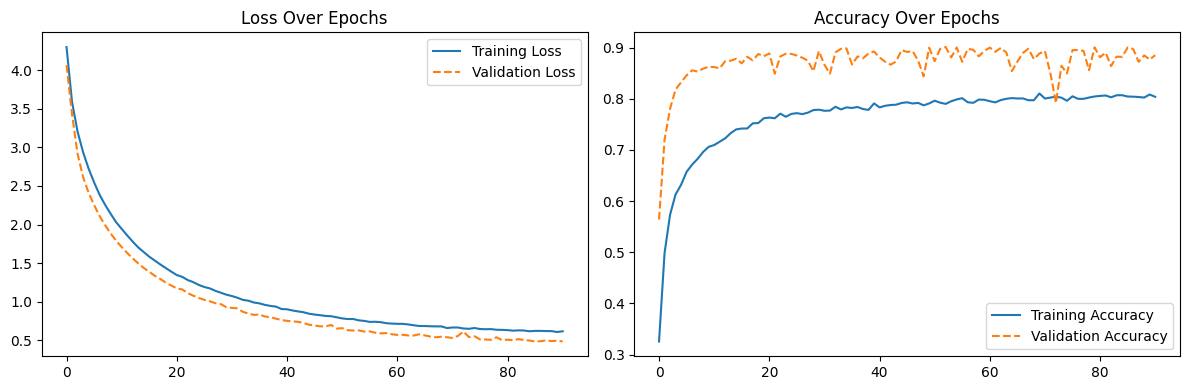

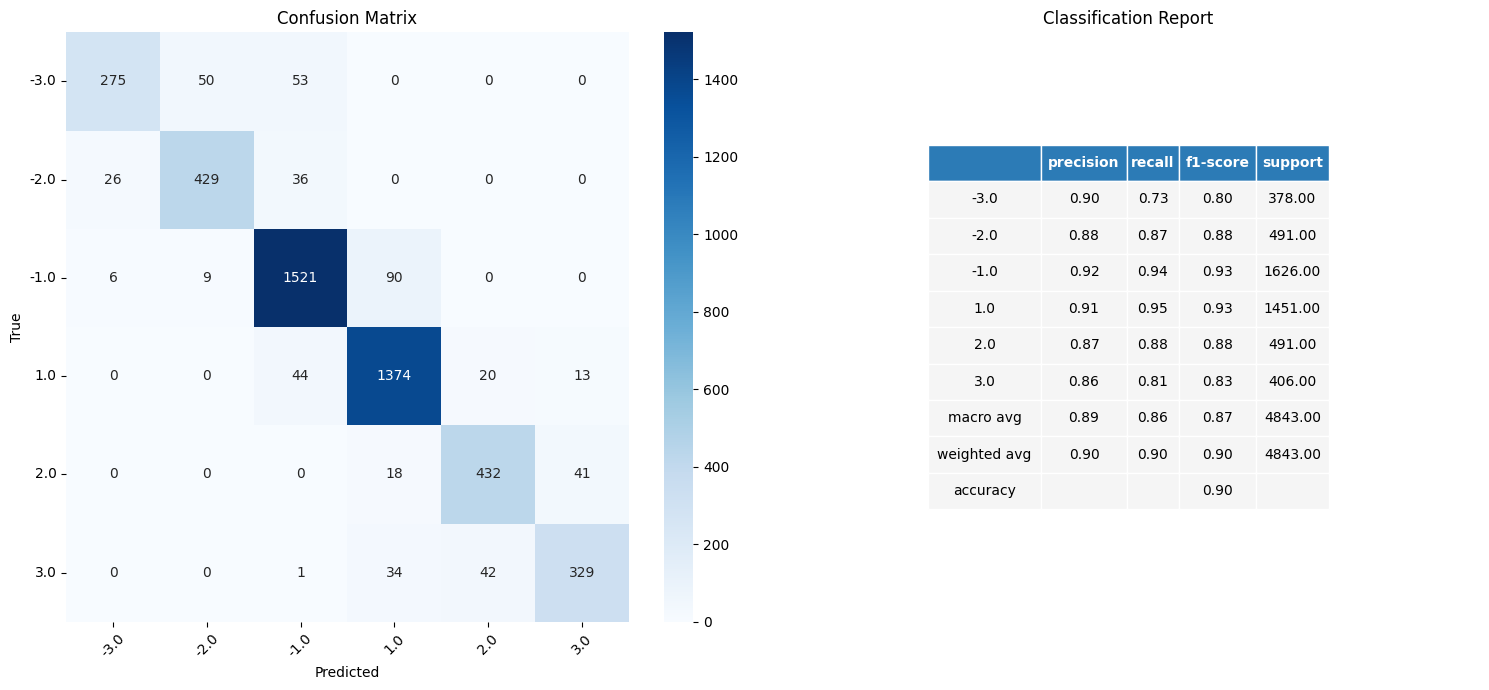

In [15]:
model =  train_dl_trend_prediction_model(df, T, model_name = f'dl_btc_ema_{predict_period}hr_trend', test_size=0.2, epochs=300)

---

### Test Model with Live Data

**Fetch BTCUSDT-1h data 1,000 rows from binance API**

In [16]:
import requests
import pandas as pd
import json
import datetime

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)

    # set datetime as index
    df = df.set_index('datetime')

    # data shape
    print(f"Data shape: {df.shape}")

    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

Data shape: (999, 5)
                         open      high       low     close      volume
datetime                                                               
2023-09-10 15:00:00  25773.24  25797.49  25712.60  25775.01   874.99633
2023-09-10 16:00:00  25775.02  25791.17  25650.00  25791.17  1385.48155
2023-09-10 17:00:00  25791.16  25792.71  25672.65  25695.60  1090.06228
2023-09-10 18:00:00  25695.59  25754.21  25687.77  25728.23   490.83102
2023-09-10 19:00:00  25728.23  25860.00  25570.57  25800.00  1903.83584
                         open      high       low     close      volume
datetime                                                               
2023-10-22 01:00:00  29971.78  30075.00  29860.01  29928.73  1119.90596
2023-10-22 02:00:00  29928.73  29928.74  29843.20  29862.46   789.67678
2023-10-22 03:00:00  29862.45  29912.53  29843.49  29907.38   412.16594
2023-10-22 04:00:00  29907.38  29996.00  29897.80  29954.71   742.95530
2023-10-22 05:00:00  29954.71  30248.00  29

**Remove training data in live data**

In [17]:
# earliest date time in live data
earliest_datetime = df_live.index.min()
print(f"Remove traning data after {earliest_datetime}")

# Remove training data in df after 2023-08-10 17:00:00
df_train = df[df.index < earliest_datetime]

print(f"Original training data shape: {df.shape}")
print(f"Unseen training data shape: {df_train.shape}")

Remove traning data after 2023-09-10 15:00:00
Original training data shape: (24215, 361)
Unseen training data shape: (23245, 361)


**Train model with unseen data**

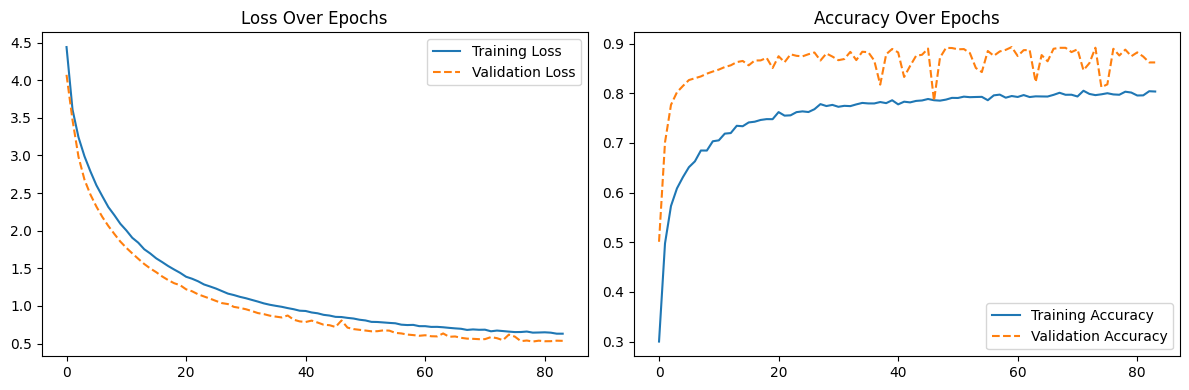

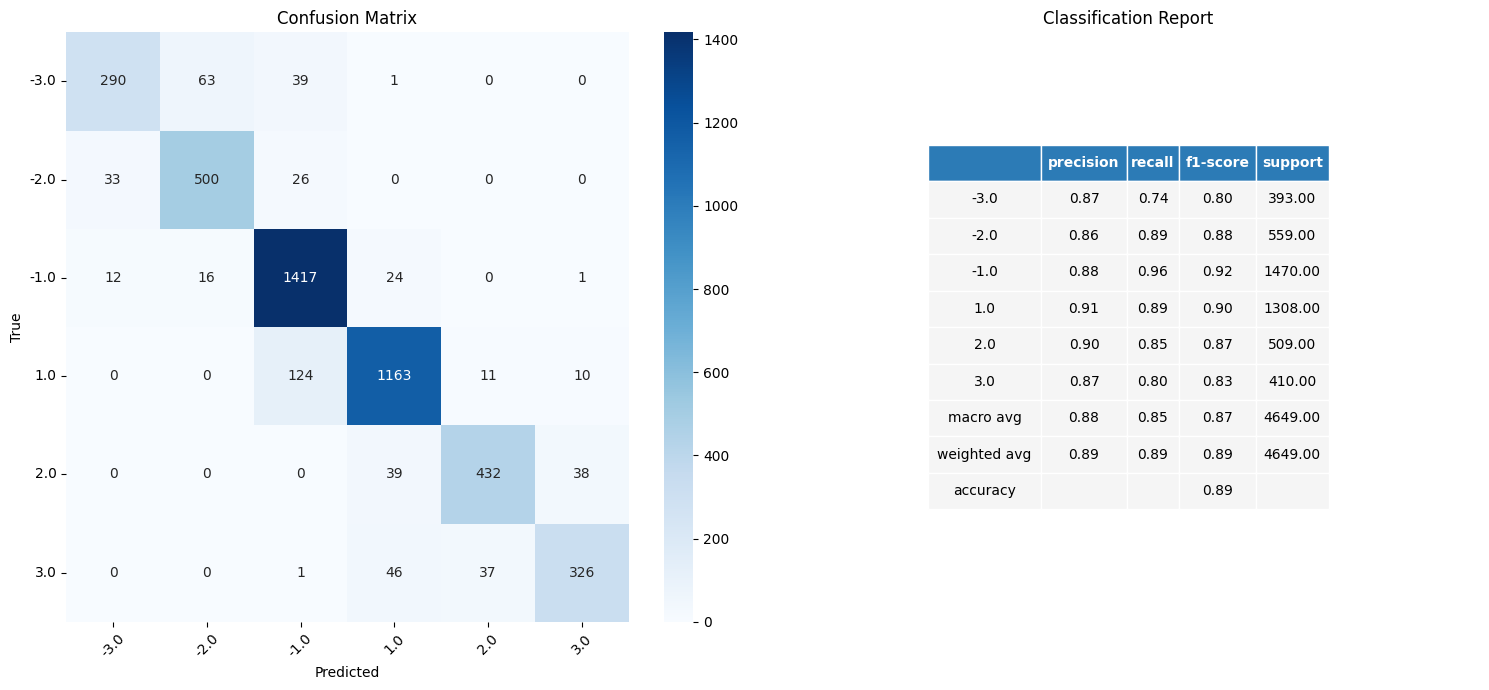

In [18]:
model =  train_dl_trend_prediction_model(df_train, T, model_name = f'dl_btc_ema_{predict_period}hr_trend_unseen', test_size=0.2, epochs=300)

**Predict and evaluate trend for live data**

In [19]:
def predict_live_data(df_live, T, model_name = 'tmp_model', model_path = './models/', feature_function='get_features_v3'):
    # Get features
    X_live = df_live.copy()
    X_live = globals()[feature_function](X_live, T=T)
    X_live.dropna(inplace=True)

    # Dimension parameters
    F = int((X_live.shape[1]) / T) # number of input features 
    # print(f"Input shape: ({T}, {F})")

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_pre = scaler.transform(X_live)

    X_live_pre = X_live_pre.reshape(-1, T, F)

    # load deep learning model
    model_filepath = model_path + model_name + '_model.keras'
    model = tf.keras.models.load_model(model_filepath)

    # predict
    y_pred = model.predict(X_live_pre, verbose=0)

    # load encoder
    encoder_filepath = model_path + model_name + '_encoder.joblib'
    encoder = joblib.load(encoder_filepath)

    # reverse one-hot encoding
    y_pred = encoder.inverse_transform(y_pred)
    y_pred = y_pred.flatten()

    # insert missing prediction with nan
    len_diff = len(df_live) - len(y_pred)
    y_pred = np.insert(y_pred, 0,  [np.nan] * len_diff, axis=0)

    return y_pred

# y_live_pred = predict_live_data(df_live, T, model_name = 'dl_btc_ema_3hr_trend_unseen')

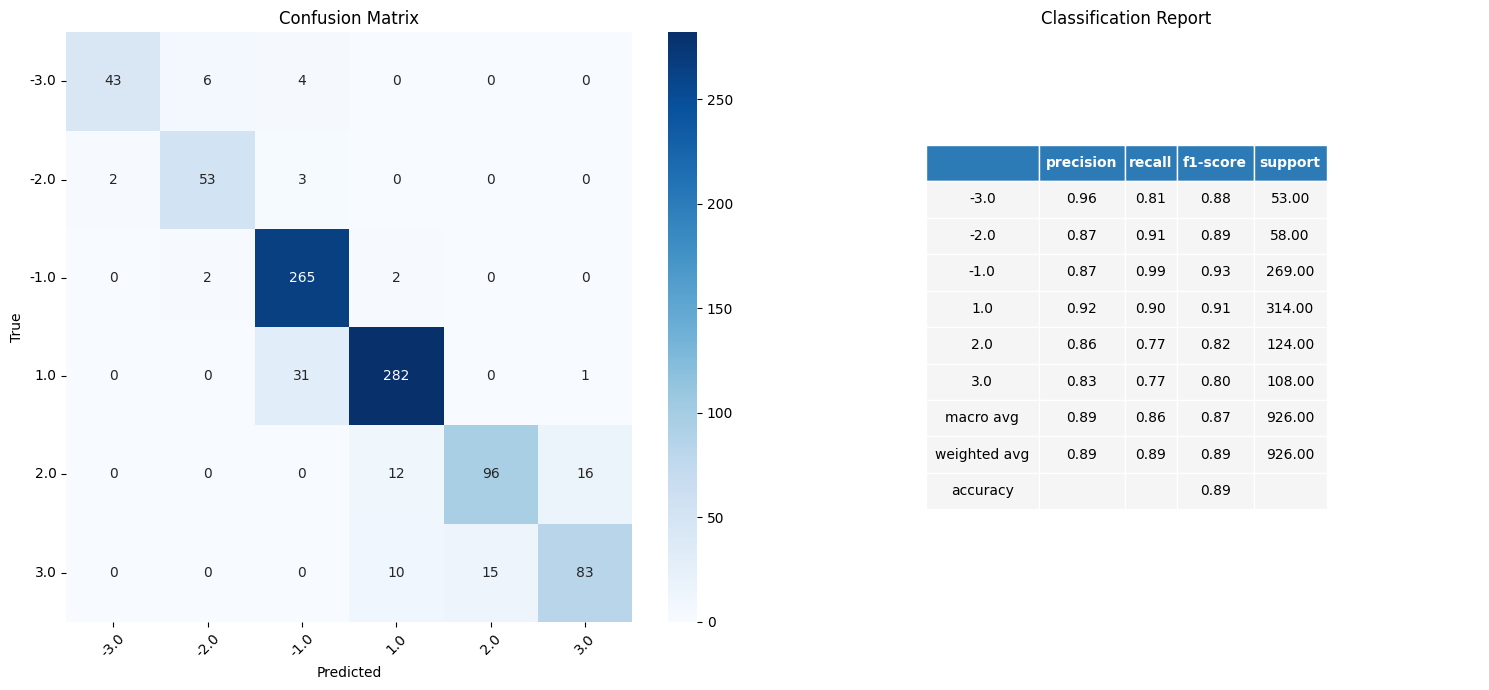

In [20]:
def evaluate_live_data(df_live, T, model_name = 'tmp_model', model_path = './models/', target_shift=3, feature_function='get_features_v3'):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, T, model_name = model_name, model_path = model_path, feature_function=feature_function)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # Get target
    pred_result = get_target_next_ema_diff_v2(pred_result, target_shift=target_shift)
    pred_result.dropna(inplace=True)

    y_test = pred_result['target']
    y_pred = pred_result['prediction']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    classes = ['-3.0', '-2.0', '-1.0', '1.0', '2.0', '3.0']

    # Confusion Matrix
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', ax=ax[0])
    ax[0].set_xticklabels(classes, rotation=45)
    ax[0].set_yticklabels(classes, rotation=0)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')
    ax[0].set_title("Confusion Matrix")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, target_names=classes)
    row_data = [["", "precision", "recall", "f1-score", "support"]]
    for k, v in report.items():
        if k not in ["accuracy"]:
            row_data.append([f"{k}"] + [f'{v[i]:.2f}' for i in ["precision", "recall", "f1-score", "support"]])
    row_data.append(["accuracy", "", "", f"{report['accuracy']:.2f}", ""])

    ax[1].axis('off')
    table = ax[1].table(cellText=row_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
    table.scale(1, 2)

    # Style the table with similar colors of the heatmap
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor('#2c7bb6')  # Header cells color
        else:
            cell.set_facecolor('#f5f5f5')  # Rest of the table color
        cell.set_edgecolor('w')  # Border color

    table.auto_set_column_width(col=list(range(5)))
    ax[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    return pred_result

pred_result = evaluate_live_data(df_live, T, model_name = f'dl_btc_ema_{predict_period}hr_trend_unseen', target_shift=predict_period, feature_function='get_features_v2')

**Predict and plot with live data**

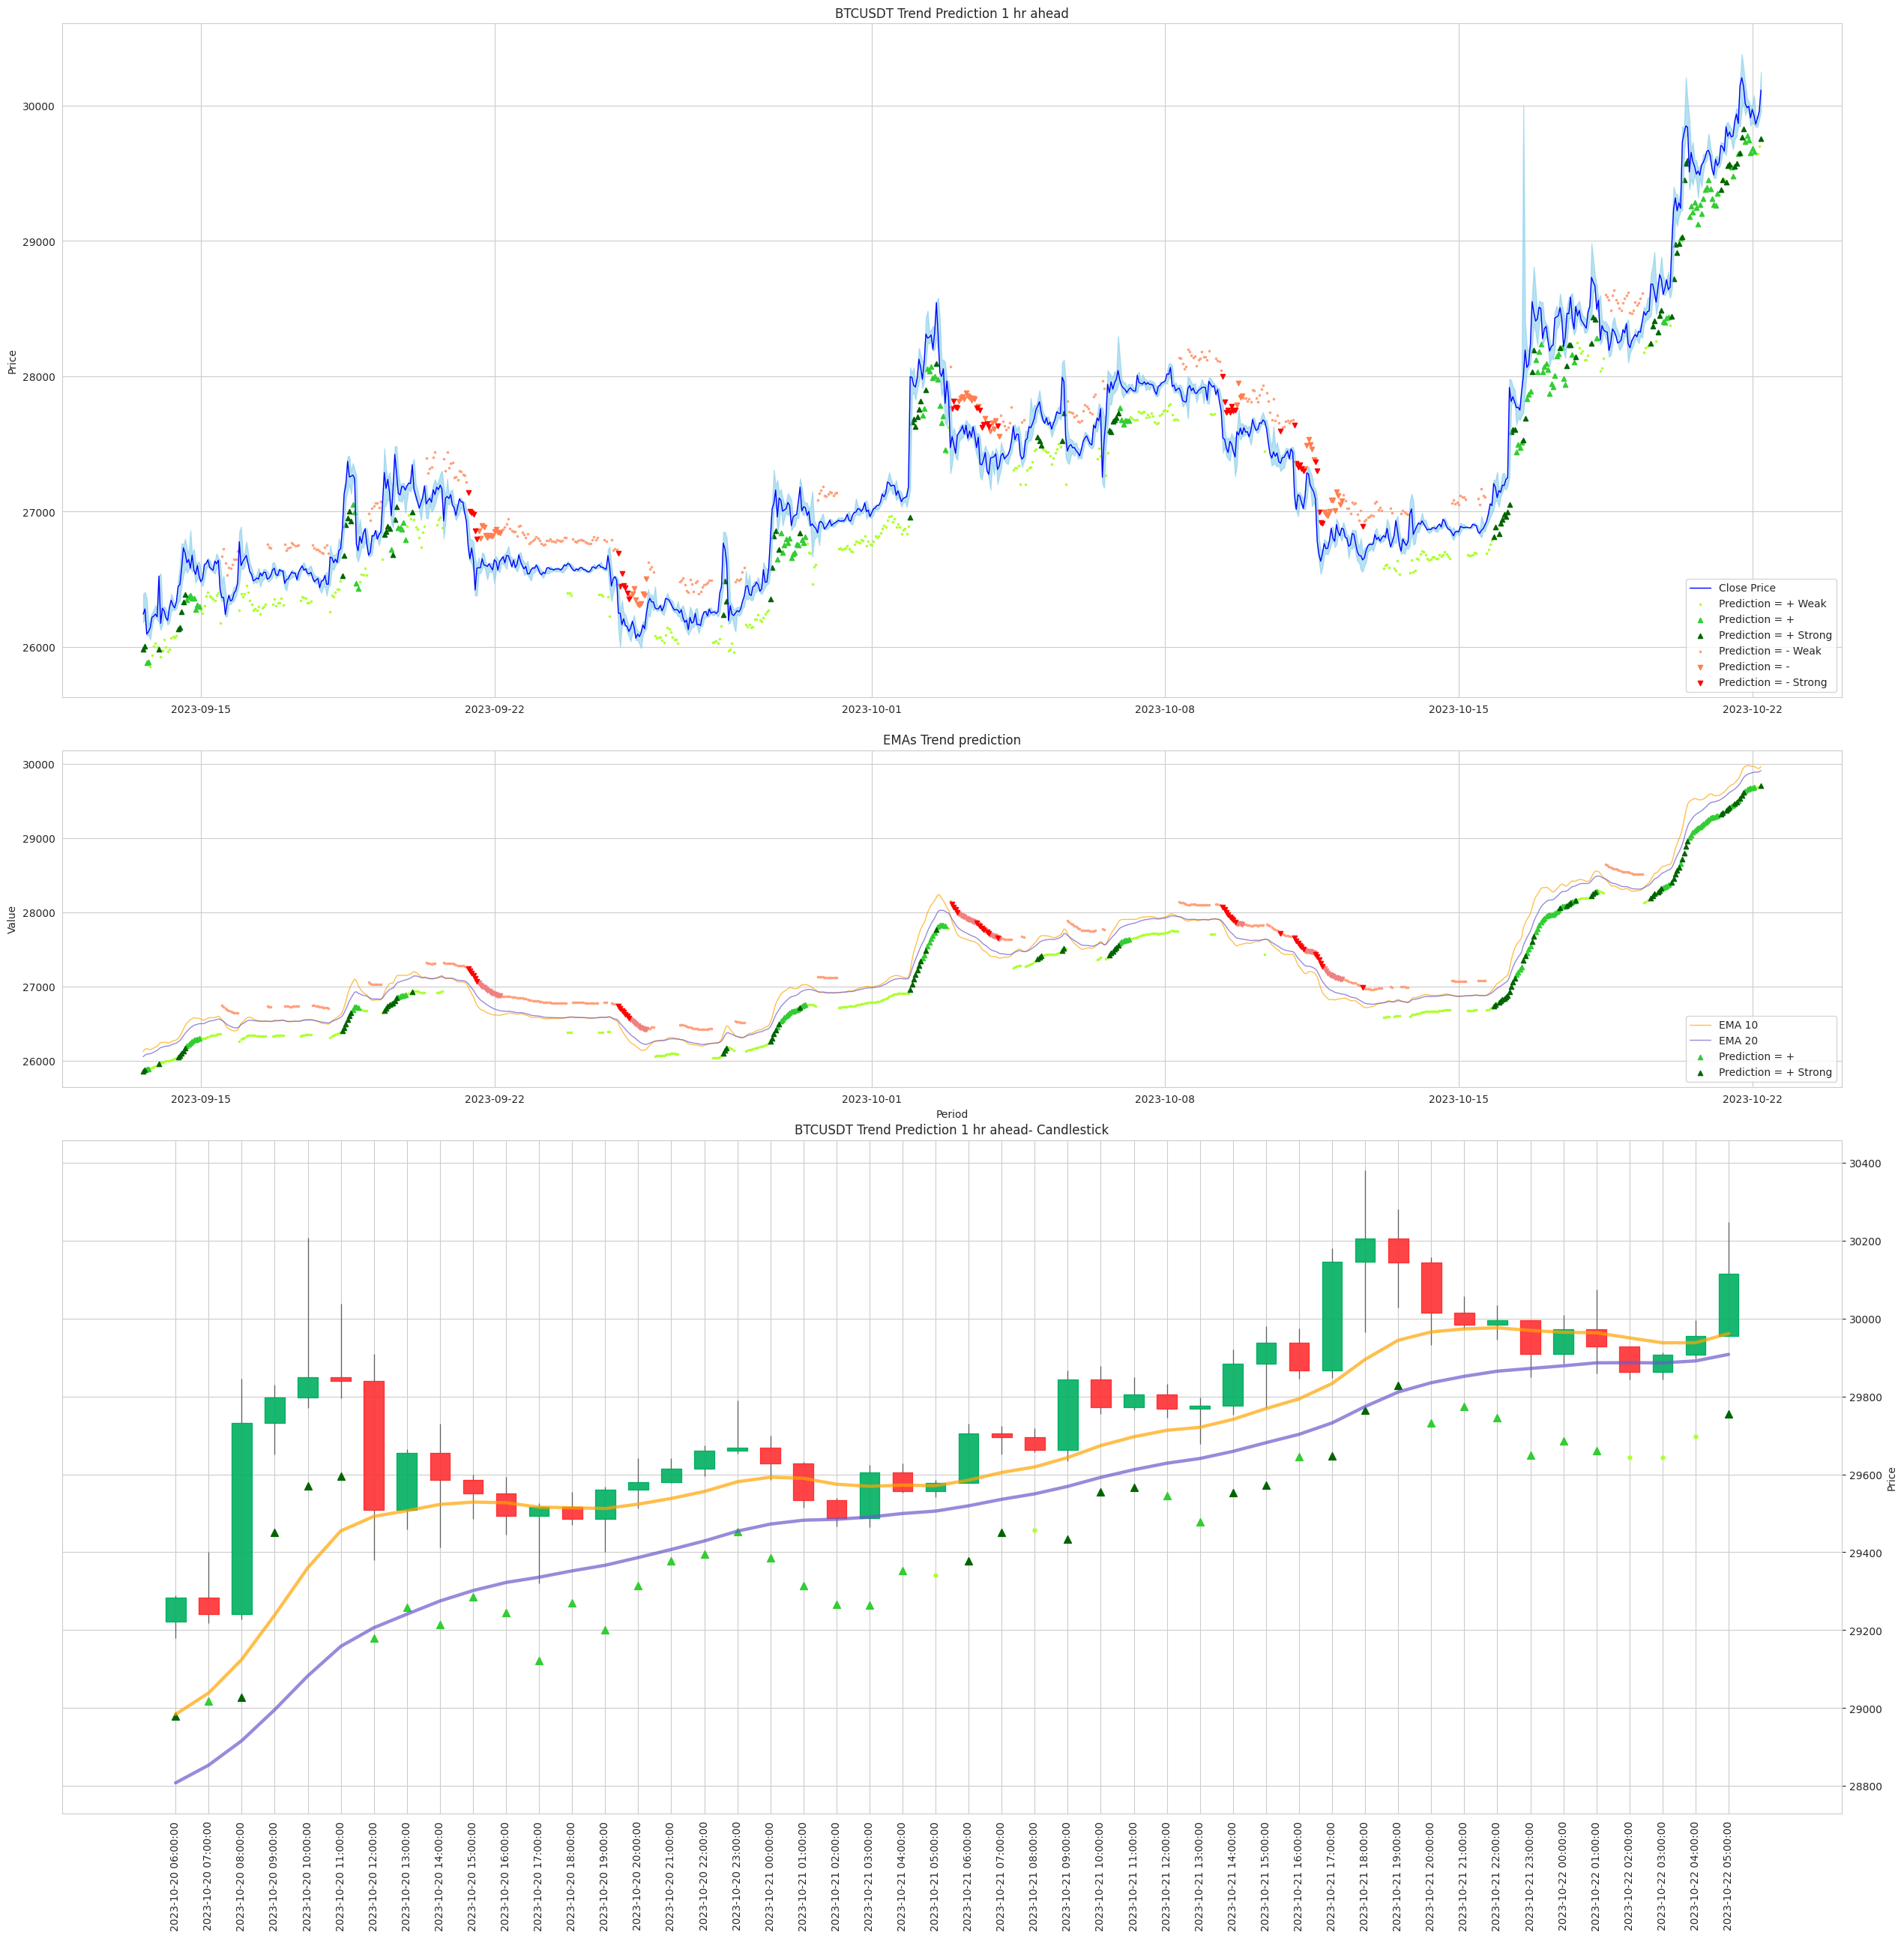

In [21]:
import talib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mplfinance as mpf

def plot_live_trend_prediction(df_live, T, model_name = 'tmp_model', model_path = './models/', feature_function='get_features_v3'):

    # Get prediction result
    y_live_pred = predict_live_data(df_live, T, model_name = model_name, model_path = model_path, feature_function=feature_function)
    
    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # ohlc
    pred_result['ohlc'] = (pred_result['open'] + pred_result['high'] + pred_result['low'] + pred_result['close']) / 4

    # diff between ema 10 and 20
    pred_result['ema_10'] = talib.EMA(pred_result['ohlc'], timeperiod=10)
    pred_result['ema_20'] = talib.EMA(pred_result['ohlc'], timeperiod=20)

    pred_result.dropna(inplace=True)

    market_space = 200

    # Initialize the marker columns with NaNs
    pred_result['prediction_price_marker_p3'] = np.nan
    pred_result['prediction_price_marker_p2'] = np.nan
    pred_result['prediction_price_marker_p1'] = np.nan
    pred_result['prediction_price_marker_m3'] = np.nan
    pred_result['prediction_price_marker_m2'] = np.nan
    pred_result['prediction_price_marker_m1'] = np.nan

    pred_result.loc[pred_result['prediction'] == 3, 'prediction_price_marker_p3'] = pred_result['low'] - market_space
    pred_result.loc[pred_result['prediction'] == 2, 'prediction_price_marker_p2'] = pred_result['low'] - market_space
    pred_result.loc[pred_result['prediction'] == 1, 'prediction_price_marker_p1'] = pred_result['low'] - market_space

    pred_result.loc[pred_result['prediction'] == -3, 'prediction_price_marker_m3'] = pred_result['high'] + market_space
    pred_result.loc[pred_result['prediction'] == -2, 'prediction_price_marker_m2'] = pred_result['high'] + market_space
    pred_result.loc[pred_result['prediction'] == -1, 'prediction_price_marker_m1'] = pred_result['high'] + market_space

    pred_result['prediction_ind_marker_p3'] = np.nan
    pred_result['prediction_ind_marker_p2'] = np.nan
    pred_result['prediction_ind_marker_p1'] = np.nan
    pred_result['prediction_ind_marker_m3'] = np.nan
    pred_result['prediction_ind_marker_m2'] = np.nan
    pred_result['prediction_ind_marker_m1'] = np.nan

    pred_result.loc[pred_result['prediction'] == 3, 'prediction_ind_marker_p3'] = pred_result['ema_20'] - market_space
    pred_result.loc[pred_result['prediction'] == 2, 'prediction_ind_marker_p2'] = pred_result['ema_20'] - market_space
    pred_result.loc[pred_result['prediction'] == 1, 'prediction_ind_marker_p1'] = pred_result['ema_20'] - market_space

    pred_result.loc[pred_result['prediction'] == -3, 'prediction_ind_marker_m3'] = pred_result['ema_20'] + market_space
    pred_result.loc[pred_result['prediction'] == -2, 'prediction_ind_marker_m2'] = pred_result['ema_20'] + market_space
    pred_result.loc[pred_result['prediction'] == -1, 'prediction_ind_marker_m1'] = pred_result['ema_20'] + market_space


    # Plot
    # Set seaborn style
    sns.set_style("whitegrid")

    # Create subplots: one for price, one for MACD histogram
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25,25), gridspec_kw={'height_ratios': [2, 1, 2]})
    fig.tight_layout(pad=3.0)

    # Plotting price data on the first subplot
    axes[0].plot(pred_result['close'], label='Close Price', color='blue', linewidth=1)

    axes[0].scatter(
            pred_result['prediction_price_marker_p1'].index, 
            pred_result['prediction_price_marker_p1'],
            color='greenyellow', 
            marker='.', 
            label='Prediction = + Weak',
            s=10,
        )

    axes[0].scatter(
            pred_result['prediction_price_marker_p2'].index, 
            pred_result['prediction_price_marker_p2'],
            color='limegreen', 
            marker='^', 
            label='Prediction = +',
            s=20
        )
    
    axes[0].scatter(
            pred_result['prediction_price_marker_p3'].index, 
            pred_result['prediction_price_marker_p3'],
            color='darkgreen', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[0].scatter(
            pred_result['prediction_price_marker_m1'].index, 
            pred_result['prediction_price_marker_m1'],
            color='lightsalmon',
            marker='.', 
            label='Prediction = - Weak',
            s=10,
        )

    axes[0].scatter(
            pred_result['prediction_price_marker_m2'].index, 
            pred_result['prediction_price_marker_m2'],
            color='coral',
            marker='v', 
            label='Prediction = -',
            s=20,
        )

    axes[0].scatter(
            pred_result['prediction_price_marker_m3'].index, 
            pred_result['prediction_price_marker_m3'],
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )
    
    axes[0].set_title(f'BTCUSDT Trend Prediction {predict_period} hr ahead')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='lower right')

    # Filling in the area between high and low prices (optional)
    axes[0].fill_between(pred_result.index, pred_result['high'], pred_result['low'], color='skyblue', alpha=0.6)

    # line plot EMA 10 and 20
    axes[1].plot(pred_result.index, pred_result['ema_10'], label='EMA 10', color='orange', alpha=0.7, linewidth=1)
    axes[1].plot(pred_result.index, pred_result['ema_20'], label='EMA 20', color='slateblue', alpha=0.7, linewidth=1)

    axes[1].scatter(
            pred_result['prediction_ind_marker_p1'].index, 
            pred_result['prediction_ind_marker_p1'],
            color='greenyellow', 
            marker='.', 
            s=10,
        )

    axes[1].scatter(
            pred_result['prediction_ind_marker_p2'].index, 
            pred_result['prediction_ind_marker_p2'],
            color='limegreen', 
            marker='^', 
            label='Prediction = +',
            s=20
        )
    
    axes[1].scatter(
            pred_result['prediction_ind_marker_p3'].index, 
            pred_result['prediction_ind_marker_p3'],
            color='darkgreen', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[1].scatter(
            pred_result['prediction_ind_marker_m1'].index, 
            pred_result['prediction_ind_marker_m1'],
            color='lightsalmon',
            marker='.', 
            s=10,
        )

    axes[1].scatter(
            pred_result['prediction_ind_marker_m2'].index, 
            pred_result['prediction_ind_marker_m2'],
            color='lightcoral',
            marker='v', 
            s=20,
        )
    
    axes[1].scatter(
            pred_result['prediction_ind_marker_m3'].index, 
            pred_result['prediction_ind_marker_m3'],
            color='red',
            marker='v', 
            s=20,
    )

    axes[1].set_title('EMAs Trend prediction')
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Period')
    axes[1].legend(loc='lower right')

    # plot candlestick
    df_candle = pred_result.iloc[-48:].copy()
    df_candle.index = pd.to_datetime(df_candle.index)

    
    # ====
    # Use mplfinance to plot on axes[2]
    # add_plot = [mpf.make_addplot(df_candle['prediction_price_marker_p1'], marker='.', color='greenyellow', markersize=100)]
    add_plot = [
        # plot EMA 10 and 20
        mpf.make_addplot(df_candle['ema_10'], ax=axes[2], color='orange', alpha=0.7),
        mpf.make_addplot(df_candle['ema_20'], ax=axes[2], color='slateblue', alpha=0.7),

        mpf.make_addplot(df_candle['prediction_price_marker_p1'], ax=axes[2], type='scatter', marker='.', color='greenyellow', markersize=50),
        mpf.make_addplot(df_candle['prediction_price_marker_p2'], ax=axes[2], type='scatter', marker='^', color='limegreen', markersize=50),
        mpf.make_addplot(df_candle['prediction_price_marker_p3'], ax=axes[2], type='scatter', marker='^', color='darkgreen', markersize=50),
        mpf.make_addplot(df_candle['prediction_price_marker_m1'], ax=axes[2], type='scatter', marker='.', color='lightsalmon', markersize=50),
        mpf.make_addplot(df_candle['prediction_price_marker_m2'], ax=axes[2], type='scatter', marker='v', color='coral', markersize=50),
        mpf.make_addplot(df_candle['prediction_price_marker_m3'], ax=axes[2], type='scatter', marker='v', color='red', markersize=50),
    ]
    mpf.plot(df_candle, type='candle', ax=axes[2], addplot=add_plot, style='yahoo')

    # Adjust the x-axis of the candlestick plot
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=len(df_candle)))
    axes[2].set_xticks(range(0, len(df_candle.index), 1))
    axes[2].set_xticklabels(df_candle.index, rotation=90)

    # set plot title
    axes[2].set_title(f'BTCUSDT Trend Prediction {predict_period} hr ahead- Candlestick')


    plt.show()

    # print(pred_result.head(5))
    # print(pred_result.tail(5))

plot_live_trend_prediction(df_live, T, model_name = f'dl_btc_ema_{predict_period}hr_trend_unseen', feature_function='get_features_v2')